In [1]:
from CASBI.generator import *
import CASBI.utils as utils 

import torch
import pandas as pd

In [2]:
test_set_file = '../../data/test_and_nll/test_set.parquet'
# model_snapshot = './snapshot/snapshot_best.pth'
model_snapshot = '../../MW_MH/tests/architecture/distributed/test_set_implemetantion/snapshot_12_256_3_02.pth'
inverse_rescale_file = '../../data/preprocess/mean_and_std.parquet'

In [3]:
Flow = NF_condGLOW(12, dim_notcond=2, dim_cond=12, CL=NSF_CL2, network_args=[256, 3, 0.2]).to('cuda:0')
Flow.load_state_dict(torch.load(model_snapshot)['MODEL_STATE'])

<All keys matched successfully>

In [4]:
test_set = pd.read_parquet('../../data/test_and_nll/test_set.parquet')
test_set = utils.rescale(df=test_set, mean_and_std_path=inverse_rescale_file, inverse=True)

df_sample = utils.create_sample_df(df_to_sample=test_set, Flow=Flow, inverse_rescale_file=inverse_rescale_file)

/export/home/vgiusepp/miniconda3/envs/test/lib/python3.10/site-packages/CASBI/utils.py:421: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, generated_data])


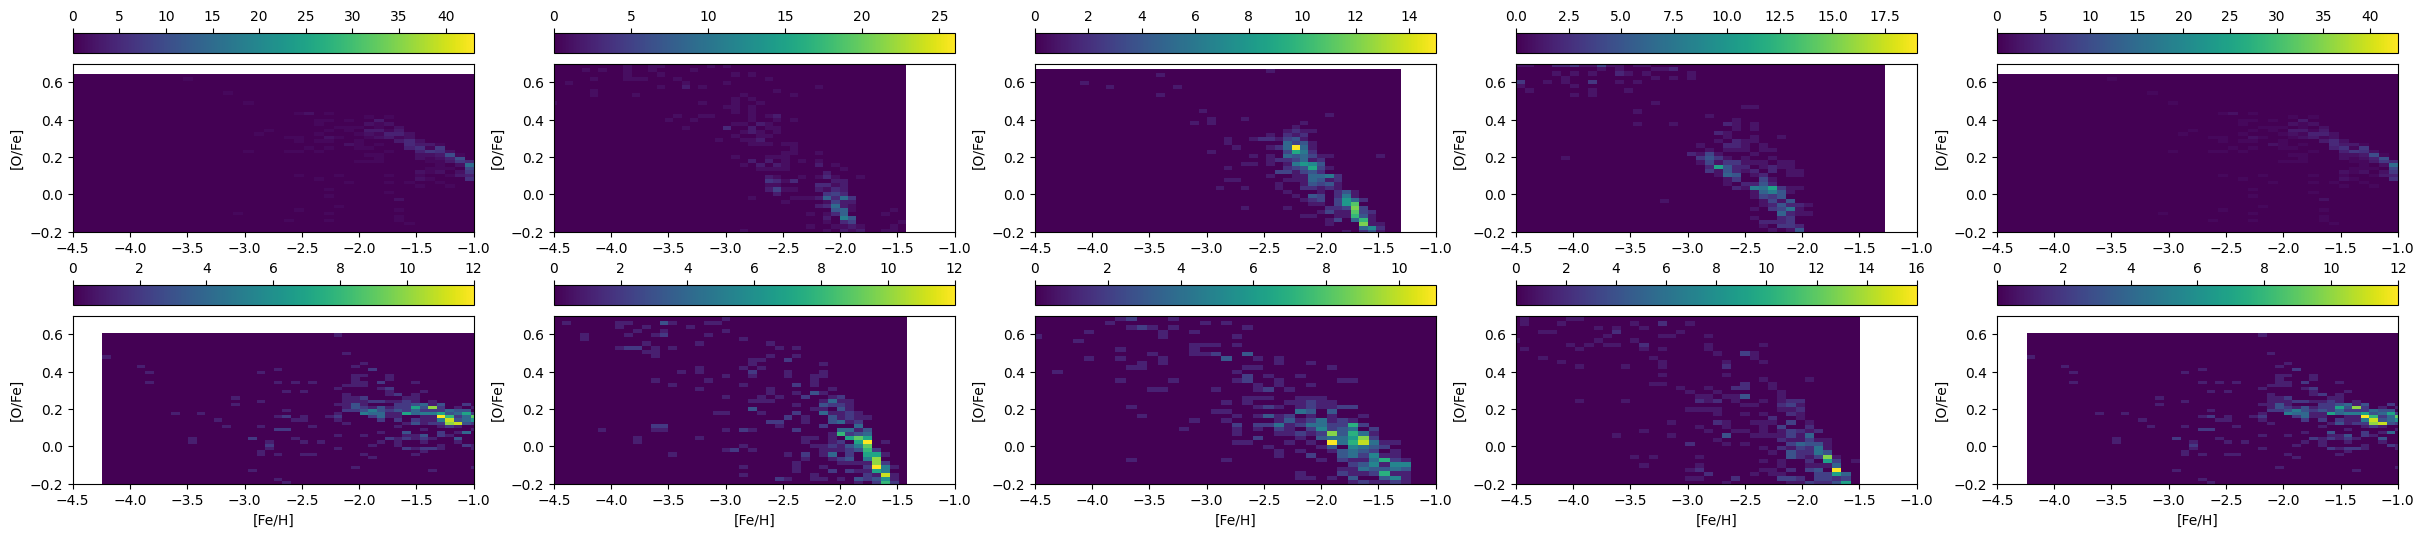

In [5]:
fig = plt.figure(figsize=(30, 6))
bad_column = ['Galaxy_name']
other_columns = test_set.columns.difference(bad_column, sort=False)

i=0
for galaxy in np.random.choice(test_set['Galaxy_name'].unique(), size=5):
    true_galaxy_plot = test_set[test_set['Galaxy_name']==galaxy]
    sample_galaxy_plot = df_sample[df_sample['Galaxy_name']==galaxy]
    i+=1
    ax = fig.add_subplot(2,5,i)
    cax = ax.hist2d(true_galaxy_plot['feh'], true_galaxy_plot['ofe'],
                    bins=50);
    fig.colorbar(cax[3], ax=ax, location='top')
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    ax.set_ylabel('[O/Fe]')
    
    ax = fig.add_subplot(2, 5, i+5)
    cax = ax.hist2d(sample_galaxy_plot['feh'], sample_galaxy_plot['ofe'], bins=50);
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    fig.colorbar(cax[3], ax=ax, location='top')

100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


<KL>: 6657.08, <JS>:, 0.27, <D>: 0.45, NLL:, 3.43


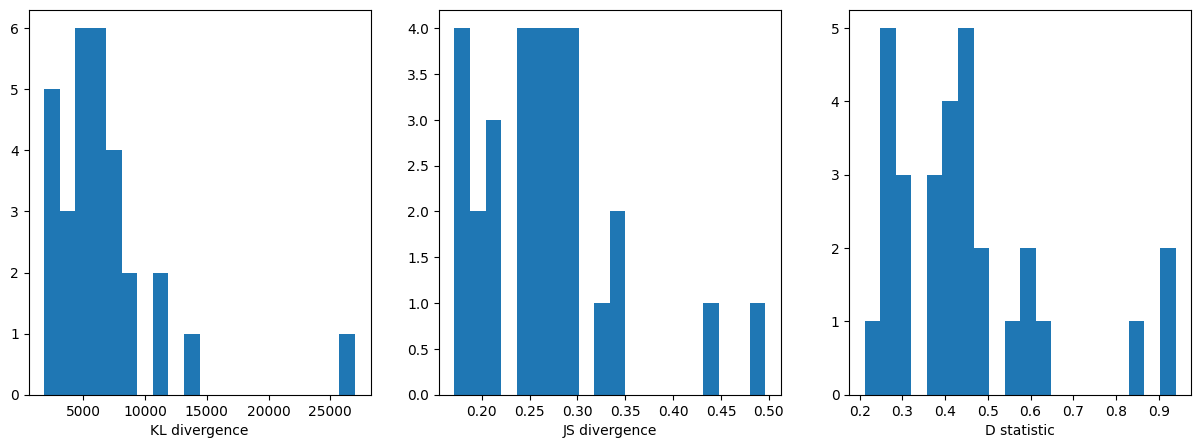

In [6]:
kl_mean, js_mean, D_mean = utils.get_test_metric(test_set, df_sample, Flow, inverse=True, inverse_rescale_file=inverse_rescale_file)
nll = np.load('../../data/test_and_nll/test_loss.npz')['nll']

print(f'<KL>: {kl_mean:.2f}, <JS>:, {js_mean:.2f}, <D>: {D_mean:.2f}, NLL:, {nll[0]:.2f}')

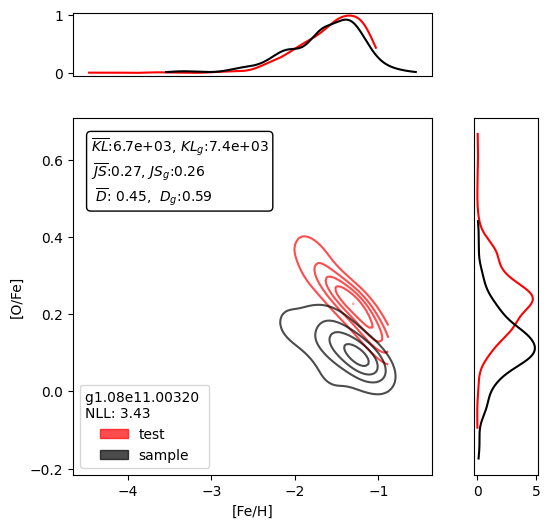

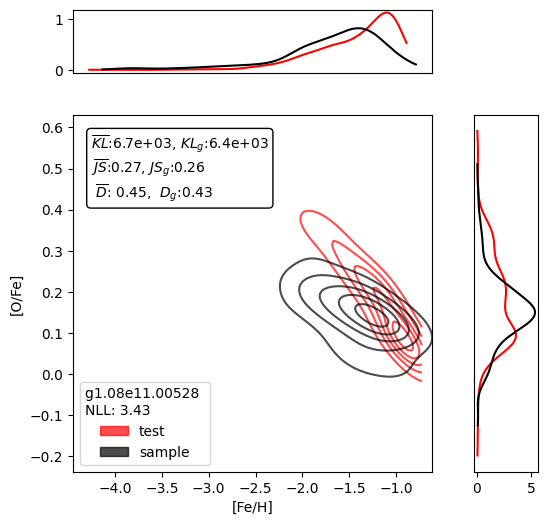

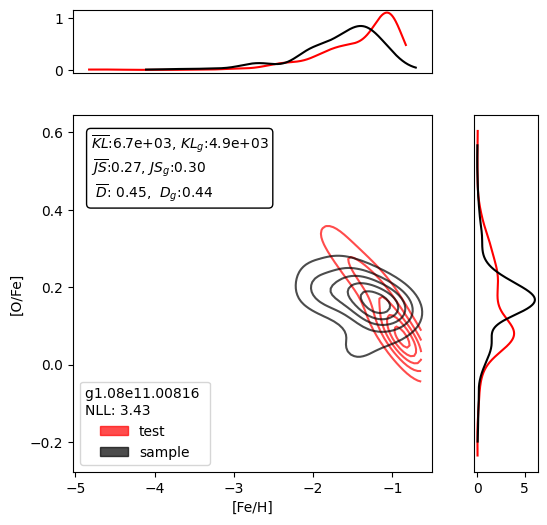

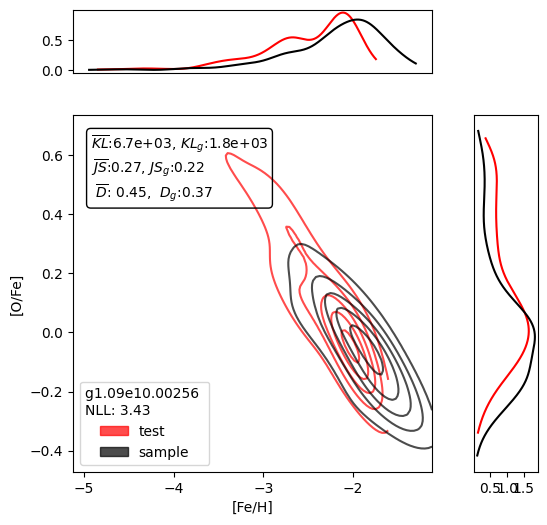

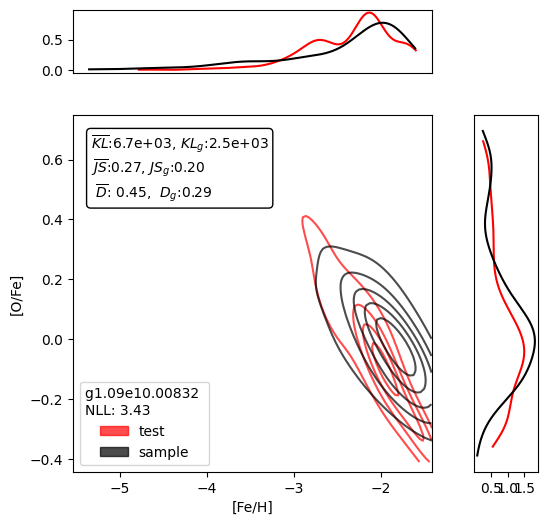

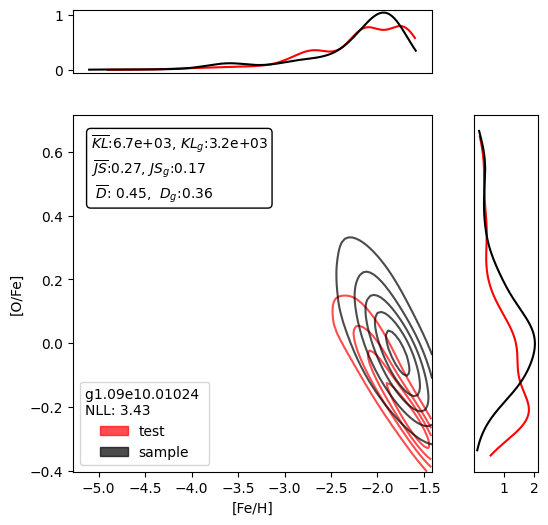

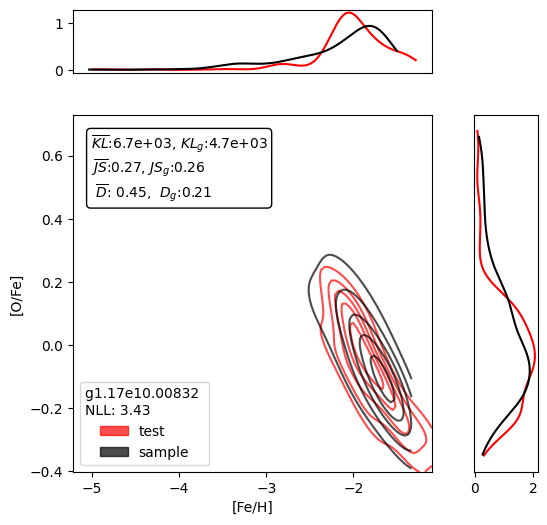

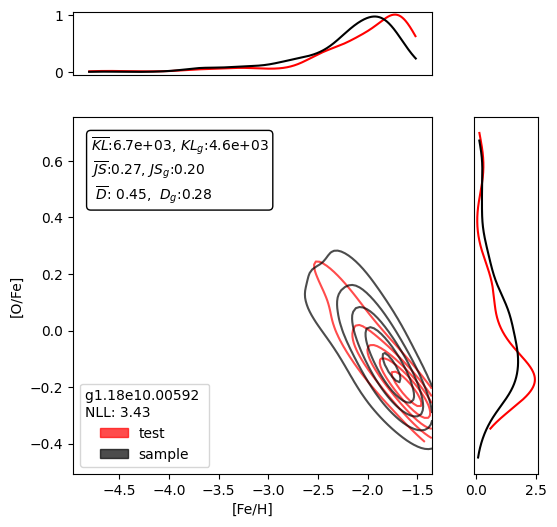

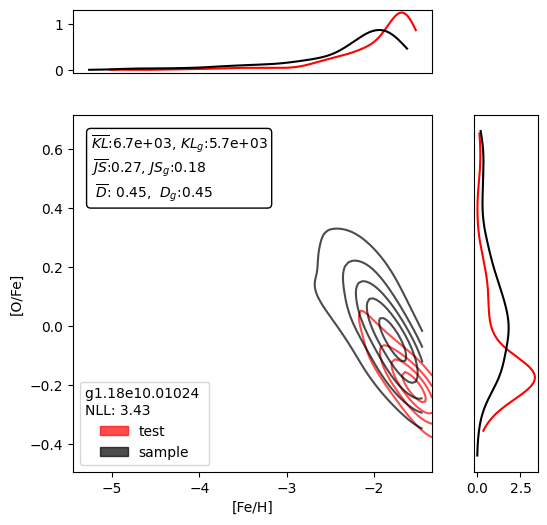

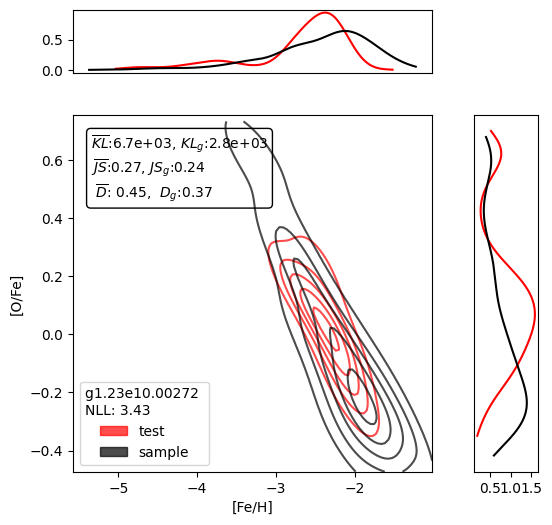

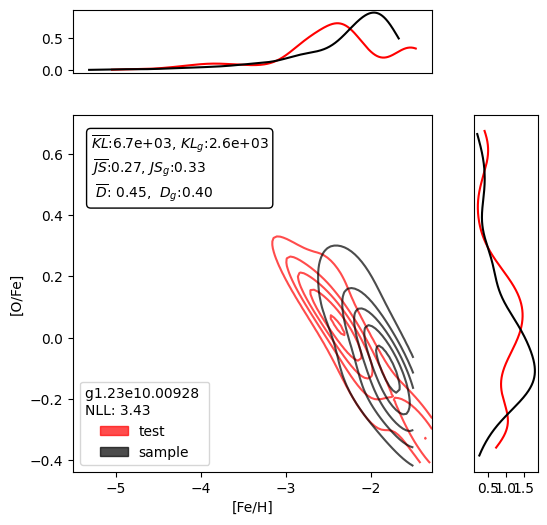

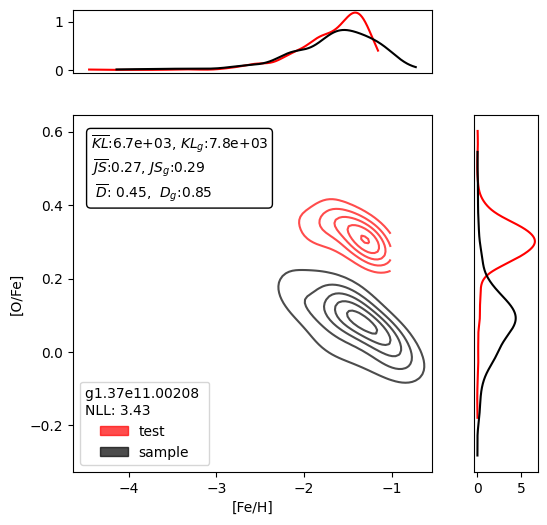

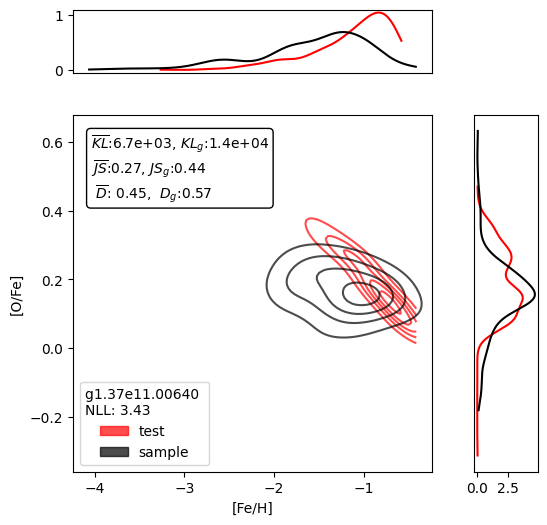

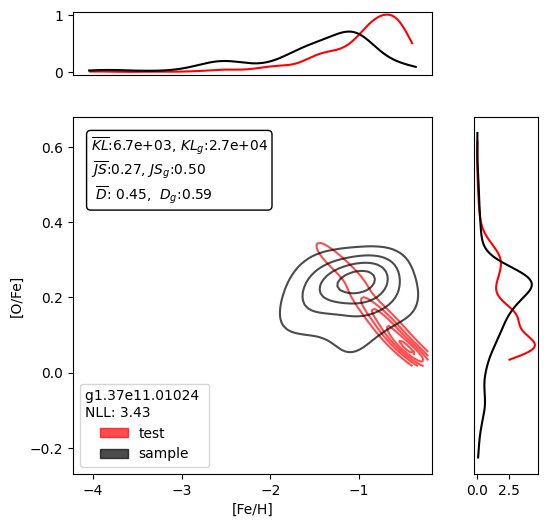

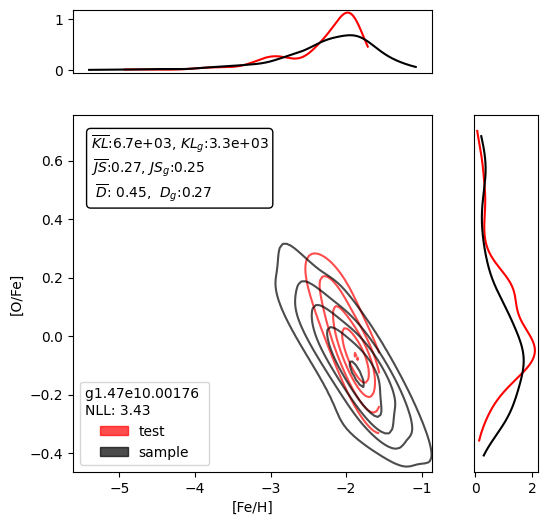

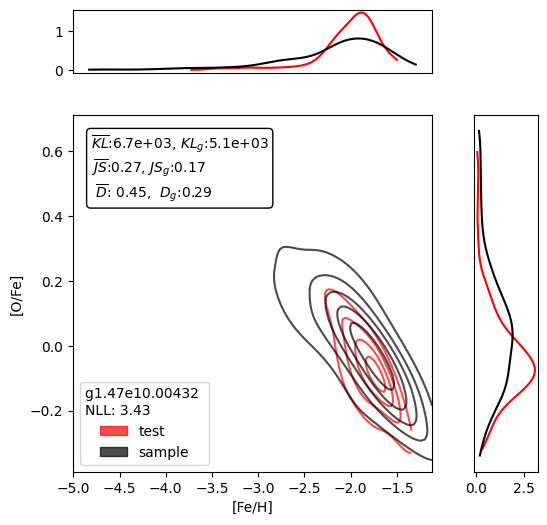

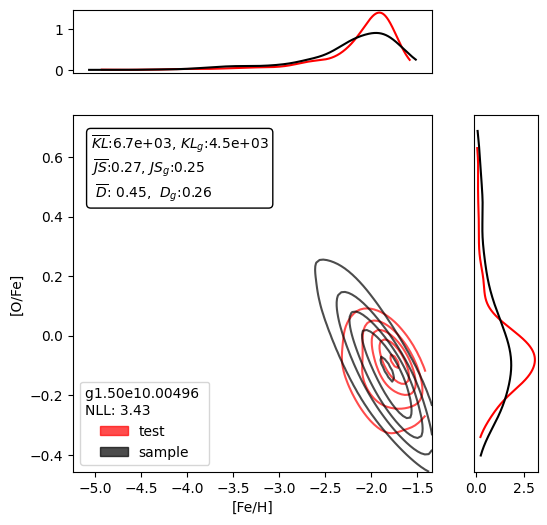

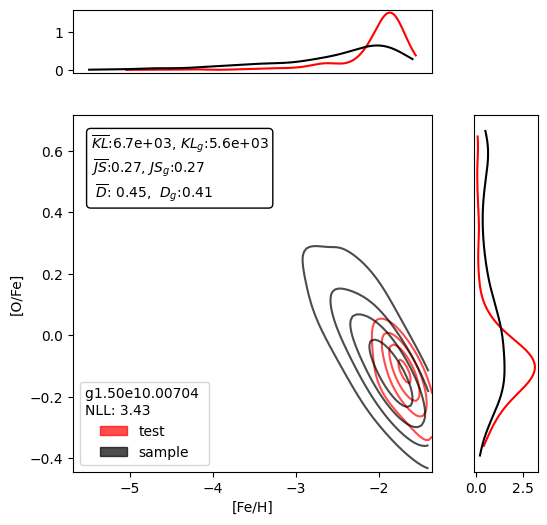

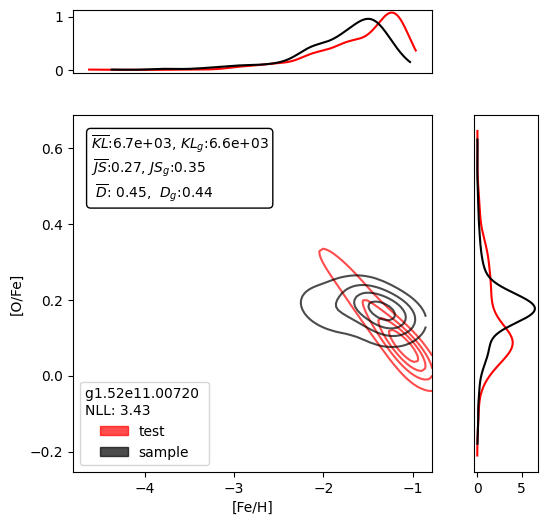

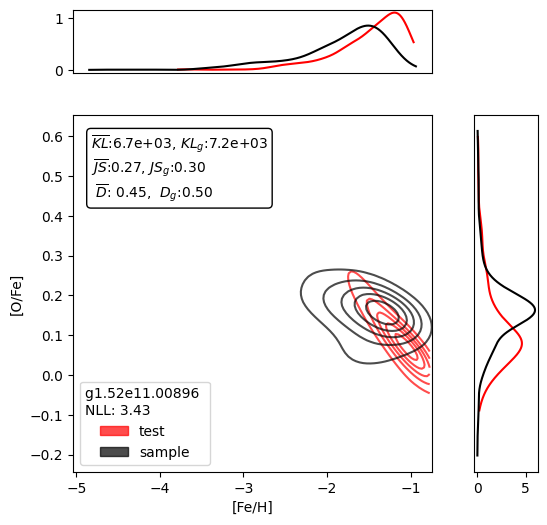

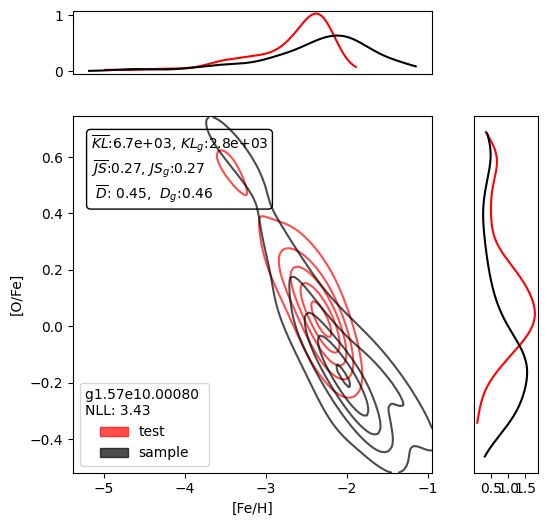

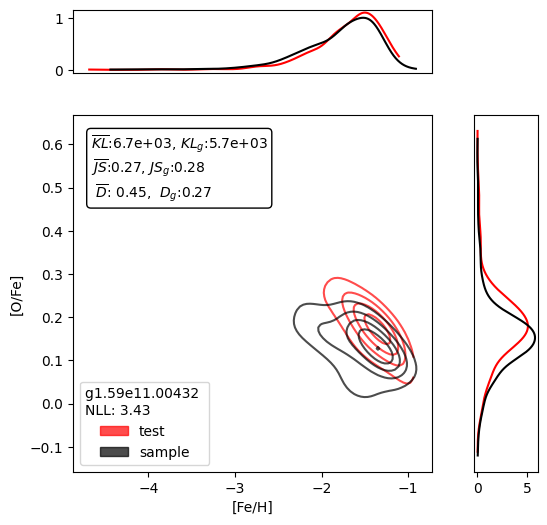

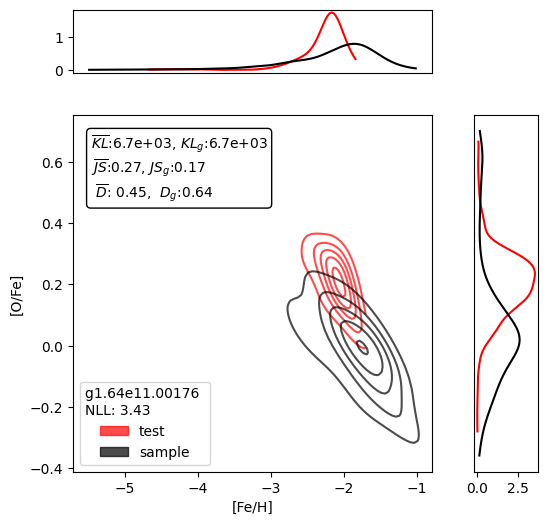

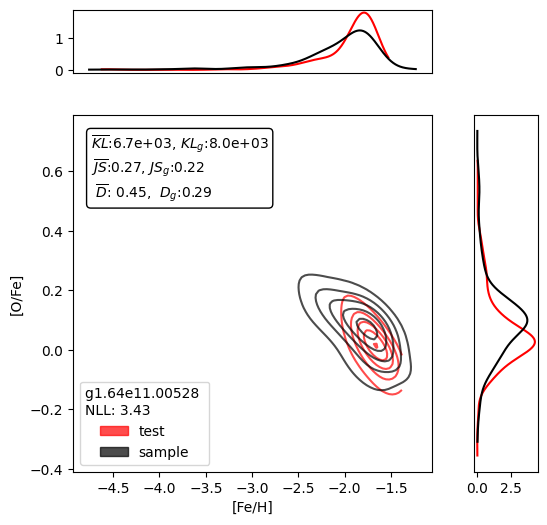

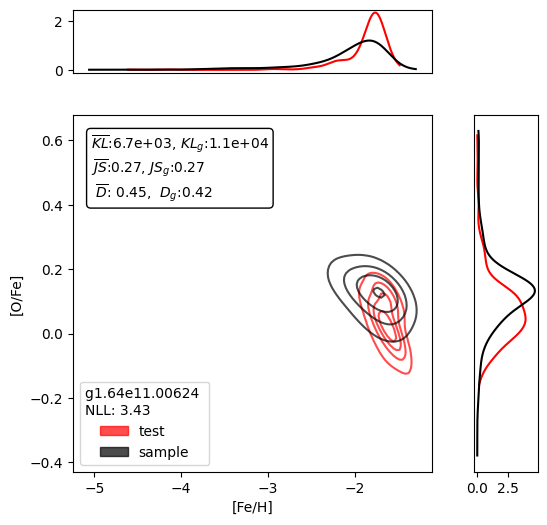

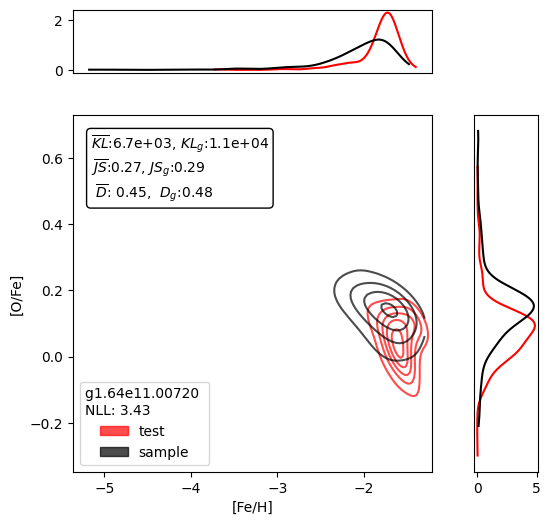

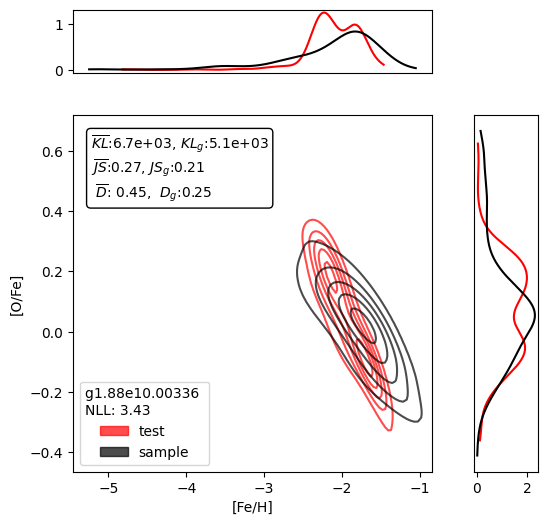

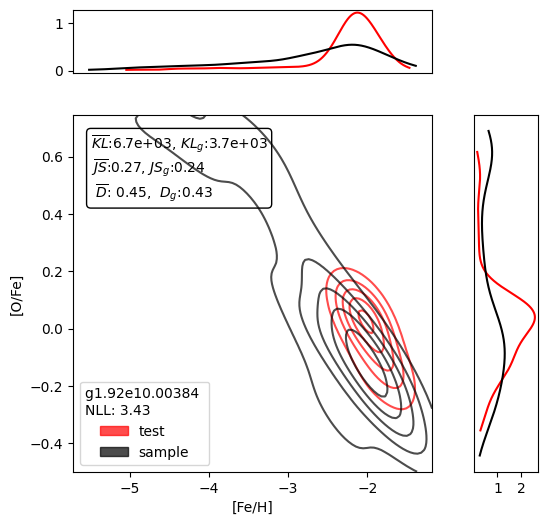

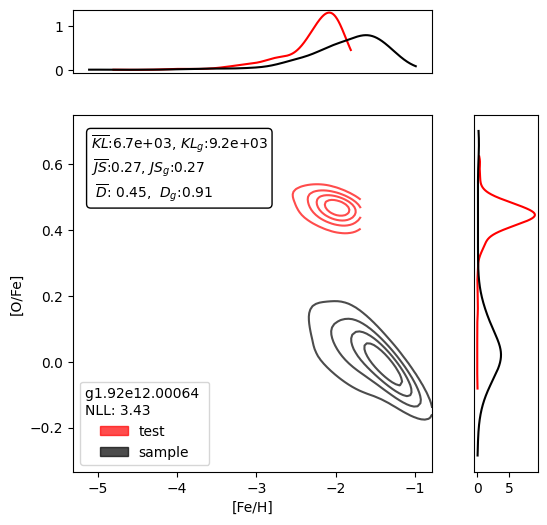

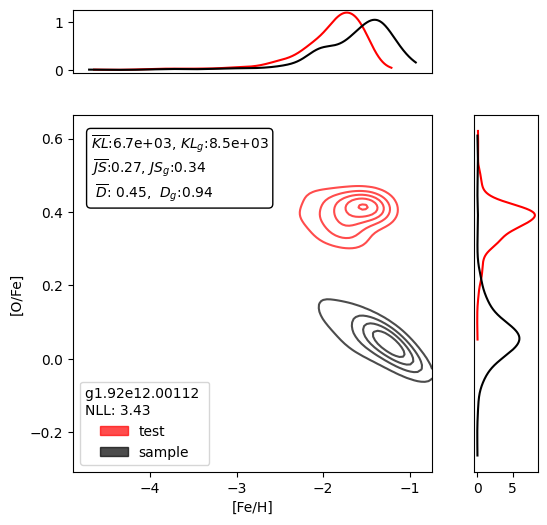

In [7]:
for galaxy in sorted(test_set['Galaxy_name'].unique()):    
        galaxy_test_set = test_set[test_set['Galaxy_name']==galaxy]
        galaxy_sample = df_sample[df_sample['Galaxy_name']==galaxy]
        
        utils.custom_kde_plot(test_df=galaxy_test_set, df_sample=galaxy_sample, Flow=Flow, inverse=True, inverse_rescale_file=inverse_rescale_file, nll=nll, kl_mean=kl_mean, js_mean=js_mean, D_mean=D_mean, levels=5)
        plt.show()